In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import optim
import random
from copy import deepcopy
import time
import pprint
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
TOPIC = 'economics'

In [ ]:
# read in classification dataset and store in dataframe
df = pd.read_csv(f'/content/gdrive/MyDrive/data/eval_data/query_classification/{TOPIC}/{TOPIC}.tsv', sep=' ', index_col=0)

In [ ]:
df.head(n=10)

,title,abstract_sentence,category,sample_type
0,wages and productivity: structural changes are...,despite a tight labor market wage and producti...,economics,1
1,coase and bertrand on lighthouses,coase journal of low and economics 17 2 185 21...,economics,1
2,indifference or indecisiveness? choice-theoret...,abstract a commonly held belief in economics i...,economics,1
3,are we spending too many years in school? caus...,this paper analyzes the impact of shortening t...,economics,1
4,explaining the recent divergence in payroll an...,each month the government releases two estimat...,economics,1
5,multinary group identification: multinary grou...,group identification refers to the problem of ...,economics,1
6,determining economic production quantity in th...,the classical economic production quantity epq...,economics,1
7,russia and the eu: the clash of new neighbourh...,the enlargement of the eu eastwards and the de...,economics,1
8,growth effects of fiscal policy of india states,as witnessed in the recent past lopsided regio...,economics,1
9,social and educational characteristics of vill...,based on empirical information the proportion ...,economics,1


In [ ]:
train_percent = 0.3
validation_percent = 0.01
test_percent = 0.01

df = df.sample(frac=1)
a = int(len(df)*train_percent)
b = int(a + len(df)*validation_percent)
c = int(b + len(df)*test_percent)

train_data = df[0:a]
validation_data = df[a:b]
test_data = df[b:c]

print(train_data.head())
print(validation_data.head())
print(test_data.head())

                                                    title  \
415929  an unholy alliance: the european far right and...   
302197      incentives to innovate in a cournot oligopoly   
226223  bonos colateralizados como alternativa de solu...   
378897           firm entry and exit in iowa, 1992 - 2004   
141847  the relationship between agency theory, stakeh...   

                                        abstract_sentence   category  \
415929  background occupational exposure to blood and ...  economics   
302197  article i section 2 of the constitution requir...  economics   
226223  agriculture consumes more than two thirds of g...  economics   
378897  in this paper we propose new panel tests to de...  economics   
141847  purpose in relation to the critical problem th...  economics   

        sample_type  
415929            0  
302197            0  
226223            0  
378897            0  
141847            1  
                                                    title  \
26245  

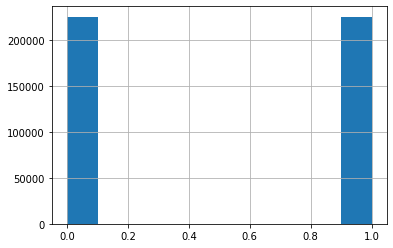

In [ ]:
df['sample_type'].hist()

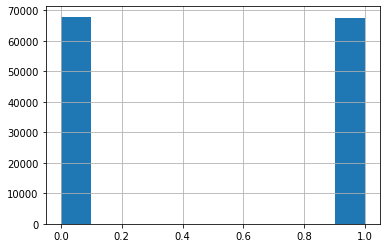

In [ ]:
train_data['sample_type'].hist()

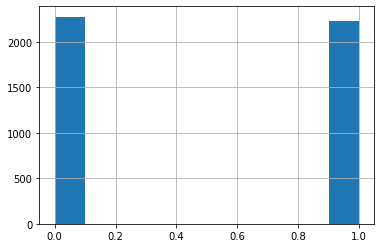

In [ ]:
validation_data['sample_type'].hist()

In [ ]:
class SentenceExample:
    """
    Data wrapper for a single example for sentiment analysis.

    Attributes:
        words (List[string]): list of words
        label (int): 0 or 1 (0 = negative, 1 = positive)
    """

    def __init__(self, title, sentence, label):
        self.title = title
        self.sentence = sentence
        self.label = label

    def __repr__(self):
        return repr(self.title) + "; sentence" + repr(self.sentence) + "; label=" + repr(self.label)

    def __str__(self):
        return self.__repr__()

In [ ]:
class Indexer(object):
    """
    Bijection between objects and integers starting at 0. Useful for mapping
    labels, features, etc. into coordinates of a vector space.

    Attributes:
        objs_to_ints
        ints_to_objs
    """
    def __init__(self):
        self.objs_to_ints = {}
        self.ints_to_objs = {}

    def __repr__(self):
        return str([str(self.get_object(i)) for i in range(0, len(self))])

    def __str__(self):
        return self.__repr__()

    def __len__(self):
        return len(self.objs_to_ints)

    def get_object(self, index):
        """
        :param index: integer index to look up
        :return: Returns the object corresponding to the particular index or None if not found
        """
        if (index not in self.ints_to_objs):
            return None
        else:
            return self.ints_to_objs[index]

    def contains(self, object):
        """
        :param object: object to look up
        :return: Returns True if it is in the Indexer, False otherwise
        """
        return self.index_of(object) != -1

    def index_of(self, object):
        """
        :param object: object to look up
        :return: Returns -1 if the object isn't present, index otherwise
        """
        if (object not in self.objs_to_ints):
            return -1
        else:
            return self.objs_to_ints[object]

    def add_and_get_index(self, object, add=True):
        """
        Adds the object to the index if it isn't present, always returns a nonnegative index
        :param object: object to look up or add
        :param add: True by default, False if we shouldn't add the object. If False, equivalent to index_of.
        :return: The index of the object
        """
        if not add:
            return self.index_of(object)
        if (object not in self.objs_to_ints):
            new_idx = len(self.objs_to_ints)
            self.objs_to_ints[object] = new_idx
            self.ints_to_objs[new_idx] = object
        return self.objs_to_ints[object]

In [ ]:
class WordEmbeddings:
    """
    Wraps an Indexer and a list of 1-D numpy arrays where each position in the list is the vector for the corresponding
    word in the indexer. The 0 vector is returned if an unknown word is queried.
    """
    def __init__(self, word_indexer, vectors):
        self.word_indexer = word_indexer
        self.vectors = vectors

    def get_embedding_length(self):
        return len(self.vectors[0])

    def get_embedding(self, word):
        """
        Returns the embedding for a given word
        :param word: The word to look up
        :return: The UNK vector if the word is not in the Indexer or the vector otherwise
        """
        word_idx = self.word_indexer.index_of(word)
        if word_idx != -1:
            return self.vectors[word_idx]
        else:
            return self.vectors[self.word_indexer.index_of("UNK")]

In [ ]:
CUSTOM_EMBEDDINGS = True

In [ ]:
def read_word_embeddings(embeddings_file: str) -> WordEmbeddings:
    """
    Loads the given embeddings (ASCII-formatted) into a WordEmbeddings object. Augments this with an UNK embedding
    that is the 0 vector. Reads in all embeddings with no filtering -- you should only use this for relativized
    word embedding files.
    :param embeddings_file: path to the file containing embeddings
    :return: WordEmbeddings object reflecting the words and their embeddings
    """
    f = open(embeddings_file)
    word_indexer = Indexer()
    vectors = []
    # Make position 0 a PAD token, which can be useful if you
    word_indexer.add_and_get_index("PAD")
    # Make position 1 the UNK token
    word_indexer.add_and_get_index("UNK")
    for i, line in enumerate(f):
        if CUSTOM_EMBEDDINGS and i == 0:
          continue

        if line.strip() != "":
            space_idx = line.find(' ')
            word = line[:space_idx]
            numbers = line[space_idx+1:]
            float_numbers = [float(number_str) for number_str in numbers.split()]
            vector = np.array(float_numbers)
            word_indexer.add_and_get_index(word)
            # Append the PAD and UNK vectors to start. Have to do this weirdly because we need to read the first line
            # of the file to see what the embedding dim is
            if len(vectors) == 0:
                vectors.append(np.zeros(vector.shape[0]))
                vectors.append(np.zeros(vector.shape[0]))
            vectors.append(vector)
        if i % 50000 == 0:
          print(f'done reading {i} embeddings')
    f.close()
    print("Read in " + repr(len(word_indexer)) + " vectors of size " + repr(vectors[0].shape[0]))
    # Turn vectors into a 2-D numpy array
    return WordEmbeddings(word_indexer, np.array(vectors))

In [ ]:
embeddings = read_word_embeddings("/content/gdrive/MyDrive/embeddings/word2vec/word2vec.economics.300d.txt")
print(len(embeddings.word_indexer))

done reading 50000 embeddings
done reading 100000 embeddings
done reading 150000 embeddings
done reading 200000 embeddings
done reading 250000 embeddings
Read in 274327 vectors of size 300
274327


In [ ]:
print(embeddings.word_indexer.index_of('super'))

5495


In [ ]:
train_exs = []
for i, row in train_data.iterrows():
  title = row['title'].split(' ')
  title[-1] = title[-1].strip()
  sentence = word_tokenize(row['abstract_sentence'])
  sentence[-1] = sentence[-1].strip()
  train_exs.append(SentenceExample(title,sentence, row['sample_type']))

In [ ]:
validation_exs = []
for i, row in validation_data.iterrows():
  title = row['title'].split(' ')
  title[-1] = title[-1].strip()
  sentence = word_tokenize(row['abstract_sentence'])
  sentence[-1] = sentence[-1].strip()
  validation_exs.append(SentenceExample(title, sentence, row['sample_type']))

In [ ]:
test_exs = []
for i, row in test_data.iterrows():
  title = row['title'].split(' ')
  title[-1] = title[-1].strip()
  sentence = word_tokenize(row['abstract_sentence'])
  sentence[-1] = sentence[-1].strip()
  test_exs.append(SentenceExample(title, sentence, row['sample_type']))

In [ ]:
class RNN(nn.Module):
  def __init__(self, 
               embedding_vectors,
               hidden_dim,
               output_dim):
    super().__init__()

    self.embedding_vectors = embedding_vectors
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    weights = torch.FloatTensor(self.embedding_vectors)
    self.e1 = nn.Embedding.from_pretrained(weights, padding_idx=0)
    self.e1.requires_grad_(False)

    self.gru_title = nn.GRU(input_size=len(self.embedding_vectors[0]),
                            hidden_size=self.hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
    
    self.gru_sentence = nn.GRU(input_size=len(self.embedding_vectors[0]),
                               hidden_size=self.hidden_dim,
                               num_layers=2,
                               batch_first=True,
                               bidirectional=True)
    
    self.drop = nn.Dropout(p=0.3)

    self.l1 = nn.Linear(4*self.hidden_dim, self.hidden_dim)
    self.r1 = nn.ReLU()
    self.l2 = nn.Linear(self.hidden_dim, self.output_dim)

    nn.init.xavier_uniform_(self.l1.weight)
    nn.init.xavier_uniform_(self.l2.weight)

  def forward(self, title, sentence):

    title_mask = (title != 0).type(
            torch.cuda.LongTensor if title.is_cuda else
            torch.LongTensor)
    
    title_lengths = title_mask.sum(dim=1).cpu()

    sentence_mask = (sentence != 0).type(
            torch.cuda.LongTensor if sentence.is_cuda else
            torch.LongTensor)
    
    sentence_lengths = sentence_mask.sum(dim=1).cpu()
            
    title = self.e1(title)
    sentence = self.e1(sentence)

    packed_input_title = pack_padded_sequence(title, title_lengths, batch_first=True, enforce_sorted=False)
    packed_output_title, _ = self.gru_title(packed_input_title)
    output_title, _ = pad_packed_sequence(packed_output_title, batch_first=True)

    out_forward_title = output_title[range(len(output_title)), title_lengths - 1, :self.hidden_dim]
    out_reverse_title = output_title[:, 0, self.hidden_dim:]
    out_reduced_title = torch.cat((out_forward_title, out_reverse_title), 1)
    text_fea_title = self.drop(out_reduced_title)

    packed_input_sentence = pack_padded_sequence(sentence, sentence_lengths, batch_first=True, enforce_sorted=False)
    packed_output_sentence, _ = self.gru_sentence(packed_input_sentence)
    output_sentence, _ = pad_packed_sequence(packed_output_sentence, batch_first=True)

    out_forward_sentence = output_sentence[range(len(output_sentence)), sentence_lengths - 1, :self.hidden_dim]
    out_reverse_sentence = output_sentence[:, 0, self.hidden_dim:]
    out_reduced_sentence = torch.cat((out_forward_sentence, out_reverse_sentence), 1)
    text_fea_sentence = self.drop(out_reduced_sentence)

    input_fea = torch.cat((text_fea_title, text_fea_sentence), dim=1)

    x = self.l1(input_fea)
    x = self.r1(x)
    x = self.l2(x)

    return x

In [ ]:
class RNNClassifier():
    """
    Implement your NeuralSentimentClassifier here. This should wrap an instance of the network with learned weights
    along with everything needed to run it on new data (word embeddings, etc.)
    """
    def __init__(self,
                 word_embeddings,
                 batch_size=256,
                 hidden_size=128,
                 output_size=5,
                 lr=0.001,
                 num_epochs=10,
                 seed=3):

        # indexer between words and indexes => self.word_embeddings.word_indexer (indexer in utils)
        # 2D array of weights => self.word_embeddings.vectors (in sentiment_data)
        
        self.word_embeddings = word_embeddings
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.lr = lr
        self.output_size = output_size

        # random.seed(seed)
        # torch.manual_seed(seed)

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.network = RNN(embedding_vectors=self.word_embeddings.vectors,
                           hidden_dim=hidden_size,
                           output_dim=output_size).to(self.device)

        self.print_network()

    def convert_to_idx_tensor(self, sentences):
        idx_encodings = []
        for sentence in sentences:
            idx_encoding = [0] * len(sentence)
            for idx, word in enumerate(sentence):
                word_idx = self.word_embeddings.word_indexer.index_of(word)
                idx_encoding[idx] = word_idx if word_idx != -1 else 1
            idx_encodings.append(idx_encoding)
        idx_encodings = torch.tensor(idx_encodings)
        return idx_encodings

    def pad_sentences(self, batch):
        max_len = 0
        for sentiment_ex in batch:
            sentence_title = sentiment_ex.title
            max_len = max(max_len, len(sentence_title))

        for sentiment_ex in batch:
            sentence_title = sentiment_ex.title
            sentence_title += ['PAD'] * (max_len - len(sentence_title))

        max_len = 0
        for sentiment_ex in batch:
            sentence_sentence = sentiment_ex.sentence
            max_len = max(max_len, len(sentence_sentence))

        for sentiment_ex in batch:
            sentence_sentence = sentiment_ex.sentence
            sentence_sentence += ['PAD'] * (max_len - len(sentence_sentence))

        return batch

    def train(self, train_exs, dev_exs):
        
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.network.parameters(), lr=self.lr, weight_decay=0.0001)

        max_dev_acc = 0
        best_weights = None

        for epoch in range(self.num_epochs):

            self.network.train()
            random.shuffle(train_exs)

            """
            Minibatch stuff
            """
            idx = 0
            minibatch_train_exs = []
            for i in range(0, len(train_exs), self.batch_size):
                minibatch_train_exs.append(train_exs[i:i+self.batch_size])
                self.pad_sentences(minibatch_train_exs[idx])
                idx += 1

            total_loss = 0
            for i, exs in enumerate(minibatch_train_exs):

                train_titles = [ex.title for ex in exs]
                train_sentences = [ex.sentence for ex in exs]
                train_y = [ex.label for ex in exs]

                # convert word sentences to list of indexes and train_y to tensor
                train_titles = self.convert_to_idx_tensor(train_titles)
                train_sentences = self.convert_to_idx_tensor(train_sentences)
                y = torch.tensor(train_y)

                train_titles = train_titles.to(self.device)
                train_sentences = train_sentences.to(self.device)
                y = y.to(self.device)

                output = self.network(train_titles, train_sentences)

                loss = loss_function(output, y)
                total_loss += loss
    
                # update model weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if i % 50 == 0:
                  print(f'batch {i} complete')

            # calculate validation set accuracy
            validation_titles = [ex.title for ex in dev_exs]
            validation_sentences = [ex.sentence for ex in dev_exs]
            golds = [ex.label for ex in dev_exs]
            predictions = self.predict_all(validation_titles, validation_sentences)
            num_correct = 0
            for i in range(0, len(golds)):
                if golds[i] == predictions[i]:
                    num_correct += 1

            dev_acc = num_correct/len(golds)

            if dev_acc > max_dev_acc or epoch == 0:
                max_dev_acc = dev_acc
                best_weights = deepcopy(self.network.state_dict())
                print('saving model weights...')

            print(f'Epoch Number = {epoch}, total loss = ', total_loss)
            print(f'Development Accuracy = {num_correct}/{len(golds)} = {dev_acc}')

        self.network.load_state_dict(best_weights)

    def predict(self, title, sentence) -> int:

        title = self.convert_to_idx_tensor([title])
        sentence = self.convert_to_idx_tensor([sentence])

        title = title.to(self.device)
        sentence = sentence.to(self.device)

        output = self.network(title, sentence)
        result = output.argmax(dim=1)
        return result[0]

    def predict_all(self, titles, sentences):
        """
        You can leave this method with its default implementation, or you can override it to a batched version of
        prediction if you'd like. Since testing only happens once, this is less critical to optimize than training
        for the purposes of this assignment.
        :param all_ex_words: A list of all exs to do prediction on
        :return:
        """
        return [self.predict(title, sentence) for title, sentence in zip(titles, sentences)]

    def print_network(self):
        print(self.network)

In [ ]:
def train_deep_averaging_network(train_exs, 
                                 dev_exs,
                                 word_embeddings: WordEmbeddings) -> RNNClassifier:
    """
    :param args: Command-line args so you can access them here
    :param train_exs: training examples
    :param dev_exs: development set, in case you wish to evaluate your model during training
    :param word_embeddings: set of loaded word embeddings
    :return: A trained NeuralSentimentClassifier model
    """

    # extract input information from args
    batch_size = 128 # args.batch_size
    hidden_size = 128 # args.hidden_size
    lr = 0.001 # args.lr
    num_epochs = 10 # args.num_epochs
    output_size = 2 # binary task

    classifier = RNNClassifier(word_embeddings=word_embeddings,
                               batch_size=batch_size, 
                               hidden_size=hidden_size, 
                               output_size=output_size,
                               lr=lr, 
                               num_epochs=num_epochs)

    start_time = time.time()
    classifier.train(train_exs=train_exs, dev_exs=dev_exs)
    end_time = time.time()
    total_time = int(end_time - start_time)

    print(f'Total time taken => {total_time}s')

    return classifier

In [ ]:
model = train_deep_averaging_network(train_exs, validation_exs, embeddings)

RNN(
  (e1): Embedding(274327, 300, padding_idx=0)
  (gru_title): GRU(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (gru_sentence): GRU(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.3, inplace=False)
  (l1): Linear(in_features=512, out_features=128, bias=True)
  (r1): ReLU()
  (l2): Linear(in_features=128, out_features=2, bias=True)
)
batch 0 complete
batch 100 complete
batch 200 complete
batch 300 complete
batch 400 complete
batch 500 complete
batch 600 complete
batch 700 complete
batch 800 complete
batch 900 complete
batch 1000 complete
saving model weights...
Epoch Number = 0, total loss =  tensor(484.1512, device='cuda:0', grad_fn=<AddBackward0>)
Development Accuracy = 3796/4512 = 0.8413120567375887
batch 0 complete
batch 100 complete
batch 200 complete
batch 300 complete
batch 400 complete
batch 500 complete
batch 600 complete
batch 700 complete
batch 800 complete
batch 900 complete
batch 1000 complete
saving model weights...

In [ ]:
torch.save(model.network.state_dict(), '/content/gdrive/MyDrive/models/query_classification/query_classifier.word2vec.economics.300d.pt')

In [ ]:
def get_confusion_matrix(model, exs):
  titles = [ex.title for ex in exs]
  sentences = [ex.sentence for ex in exs]
  golds = [ex.label for ex in exs]
  predictions = model.predict_all(titles, sentences)

  confusion_matrix = [[0] * 2 for i in range(2)]  
  num_correct = 0
  for i in range(0, len(golds)):
    if golds[i] == predictions[i]:
      num_correct += 1
    confusion_matrix[golds[i]][predictions[i]] += 1

  return num_correct, confusion_matrix

In [ ]:
num_correct, confusion_matrix = get_confusion_matrix(model, validation_exs)

In [ ]:
pprint.pprint(confusion_matrix)

[[1927, 352], [306, 1927]]


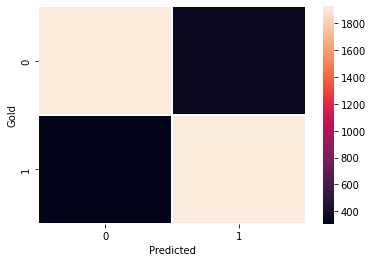

In [ ]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix, linewidth=0.3)
ax.set(xlabel='Predicted', ylabel='Gold')
plt.show()